In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.initializers import *
from keras.models import load_model
import theano.tensor as T
import theano
from sklearn import metrics
from sklearn.preprocessing import *
from scipy.fftpack import dct, idct
from keras.activations import softmax
from sklearn.cluster import KMeans, MiniBatchKMeans

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 Ti (CNMeM is disabled, cuDNN 5105)


In [2]:
# external custom code I wrote
from load_data import *
from windowing import *
from utility import *
from pesq import *
from noise import *
from consts import *
from nn_blocks import *
from transforms import *

In [3]:
# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# number of speech files for train, val, and test
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 500

# during training, we evaluate PESQ and RMSE and such on full speech files every epoch, which
# is kind of expensive. so instead of selecting the full training and validation set, we
# randomly select this many waveforms
TRAIN_EVALUATE = 50
VAL_EVALUATE = 50

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101814, 512, 1)
6.41179e-06
0.103588
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
# softmax hardness variable
tau = K.variable(0.0, name = "hardness")
tau_add_rate = 0.05
max_tau = 1.0

NBINS = 256
VEC_SIZE = 2

# initially, quantization is not on
#BINS_INIT = np.mgrid[-1:1:4j, -1:1:4j, -1:1:4j, -1:1:4j].reshape(VEC_SIZE, -1).T
#QUANT_BINS = K.variable(BINS_INIT)
QUANT_BINS = K.zeros((NBINS, VEC_SIZE), name = 'QUANT_BINS')
QUANT_BIAS = K.random_uniform_variable((VEC_SIZE,), -0.01, 0.01, name = 'QUANT_BIAS')
QUANT_SCALE = K.variable(1.0, name = 'QUANT_SCALE')
QUANTIZATION_ON = K.variable(False)

DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR

In [8]:
def unquantize_batch(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [2, 0])
    out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
    return out

def unquantize_vec(one_hot):
    out = T.tensordot(one_hot, QUANT_BINS, axes = [1, 0])
    out = K.reshape(out, (CHANNEL_SIZE,))
    return out

class SoftmaxQuantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxQuantization, self).__init__(**kwargs)
   
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(200.0)
        self.trainable_weights = [QUANT_BINS,
                                  QUANT_BIAS,
                                  self.SOFTMAX_TEMP]
        super(SoftmaxQuantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        # x is an array: [BATCH x WINDOW_SIZE]
        # x_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x 1 x VEC_SIZE]
        x_r = K.reshape(x, (-1, x.shape[1] / VEC_SIZE, 1, VEC_SIZE))
        x_r = x_r - K.reshape(QUANT_BIAS, (1, 1, 1, VEC_SIZE))

        # quant_bins is an array: [NBINS x VEC_SIZE] 
        # q_r becomes: [1 x 1 x NBINS x VEC_SIZE]
        q_r = K.reshape(QUANT_BINS, (1, 1, QUANT_BINS.shape[0], VEC_SIZE))

        # get L2 distance from each element to each of the bins
        dist = K.sqrt(K.sum(K.square(x_r - q_r), axis = -1) + K.epsilon())

        # turn into softmax probabilities, which we return
        probs = softmax(self.SOFTMAX_TEMP * -dist)
        
        # if quantization isn't on yet, we just return the original vector x, reshaped
        # and padded to the right shape
        #     (this is a bad hack and I hope there is a better way to do this)
        quant_on = probs
        quant_off = K.zeros_like(quant_on)
        quant_off = T.set_subtensor(quant_off[:, :, :VEC_SIZE],
                                    K.reshape(x, (-1, x.shape[1] / VEC_SIZE, VEC_SIZE)))
        
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] / VEC_SIZE, NBINS)


class SoftmaxDequantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxDequantization, self).__init__(**kwargs)
        self.supports_masking = False
    
    def build(self, input_shape):
        self.trainable_weights = []
        super(SoftmaxDequantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        out = T.tensordot(x, QUANT_BINS, axes = [2, 0])
        out = out + K.reshape(QUANT_BIAS, (1, 1, VEC_SIZE))
        out = K.reshape(out, (out.shape[0], out.shape[1] * VEC_SIZE))
        quant_on = out
        quant_off = K.reshape(x[:, :, :VEC_SIZE], (-1, x.shape[1] * VEC_SIZE))
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * VEC_SIZE)

In [9]:
NUM_MFCC_COEFFS = 32

# precompute Mel filterbank
MEL_FILTERBANK_NPY = melFilterBank(NUM_MFCC_COEFFS).transpose()
MEL_FILTERBANK = K.variable(MEL_FILTERBANK_NPY)

# we precompute matrices for MFCC calculation
MFCC_DFT_REAL, MFCC_DFT_IMAG = generate_dft_mats(WINDOW_SIZE)
MFCC_DCT = generate_dct_mat(NUM_MFCC_COEFFS, norm = 'ortho')

# given a (symbolic Theano) array of size M x WINDOW_SIZE (or M x WINDOW_SIZE x 1)
#     this returns an array M x NUM_MFCC_COEFFS where each window has been replaced
#     by its MFCC coeffs
def theano_mfcc(x):
    powerSpectrum = T.pow(theano_dft_mag(x, MFCC_DFT_REAL, MFCC_DFT_IMAG), 2)
    
    filteredSpectrum = T.tensordot(powerSpectrum, MEL_FILTERBANK, axes = 1)

    logSpectrum = T.log(filteredSpectrum + K.epsilon())
    #mfccs = theano_dct(filteredSpectrum, MFCC_DCT)
    return logSpectrum

# compute MFCC for single window (Numpy)
def mfcc(signal):
    complexSpectrum = fft(signal)
    
    powerSpectrum = abs(complexSpectrum) ** 2
    filteredSpectrum = np.dot(powerSpectrum, MEL_FILTERBANK_NPY)

    # get log spectrum and take DCT to get MFCC
    logSpectrum = np.log(filteredSpectrum + np.finfo(float).eps)
    #mfcc = dct(logSpectrum, type=2)

    return logSpectrum

# mfcc loss function
def mfcc_distance(y_true, y_pred):
    mfcc_true = theano_mfcc(y_true)
    mfcc_pred = theano_mfcc(y_pred)
    return rmse(mfcc_true, mfcc_pred)

In [10]:
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 9
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    #enc = channel_increase_block(NCHAN, FILT_SIZE)(enc)
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    #enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    
    #enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = channel_change_block(1, FILT_SIZE, False)(enc)
    #enc = channel_decrease_block(NCHAN, FILT_SIZE)(enc)
    
    enc = Reshape((CHANNEL_SIZE,))(enc)
    #enc = Dense(CHANNEL_SIZE)(enc)
    
    # softmax quantization
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE / VEC_SIZE, NBINS))
    dec = dec_input
    
    dec = SoftmaxDequantization()(dec)
    
    # increase number of channels via convolution
    #dec = Dense(CHANNEL_SIZE)(dec)
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    #dec = channel_increase_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    #dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    
    # decrease back down to 1 channel
    #dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(1, FILT_SIZE, False)(dec)
    #dec = channel_decrease_block(NCHAN, FILT_SIZE)(dec)
    
    dec = Activation('tanh')(dec)
    #dec = Lambda(lambda x : K.clip(x, -1.0, 1.0))(dec)
    
    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [11]:
# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -
    NCHAN = 32
    FILT_SIZE = 9
    NUM_SCALES = 4
    
    # - - - - - - - - - - - - - - - - - - - - -
    # model
    # - - - - - - - - - - - - - - - - - - - - -
    dsc_input = Input(shape = dim)
    dsc = Reshape(dim, input_shape = dim)(dsc_input)
    
    # aggregate features at multiple scales
    scales = []
    for i in xrange(0, NUM_SCALES):
        dsc = Conv1D(NCHAN, FILT_SIZE, padding = 'same',
                         kernel_initializer = W_INIT,
                         activation = 'relu')(dsc)
        dsc = Conv1D(NCHAN, FILT_SIZE, padding = 'same',
                         kernel_initializer = W_INIT,
                         activation = 'relu')(dsc)
        scl = GlobalAveragePooling1D()(dsc)
        dsc = Conv1D(NCHAN, FILT_SIZE, padding = 'same',
                         kernel_initializer = W_INIT,
                         strides = 2,
                         activation = 'relu')(dsc)
        
        scales.append(scl)
    
    vec = Average()(scales)
    dsc = Dense(32, activation = 'relu', kernel_initializer = W_INIT)(vec)

    # sigmoid output (probability of window being real or reconstructed)
    dsc = Dense(1, activation = 'sigmoid', kernel_initializer = W_INIT)(dsc)
    
    dsc = Model(inputs = dsc_input, outputs = dsc)
    return dsc

In [12]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (code.shape[0] * code.shape[1], NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    return K.switch(QUANTIZATION_ON, tau * entropy, 0.0)

#def code_sparsity(placeholder, code):
#    per_code_entropy = -K.mean(K.sum(code * K.log(code + K.epsilon()), axis = -1), axis = -1)
#    return K.switch(QUANTIZATION_ON, tau * per_code_entropy, 0.0)

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return K.switch(QUANTIZATION_ON, sparsity, 0.0)

DISCRIMINATOR_FLOW = K.variable(1.0)
def discriminator_loss(placeholder, labels):
    loss = K.binary_crossentropy(labels, K.ones_like(labels))
    return K.switch(DISCRIMINATOR_FLOW, loss, 0.0)

In [13]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'maximize_entropy' : maximize_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'EuclideanDistance': EuclideanDistance,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'NBINS' : NBINS,
                  'QUANT_BINS' : QUANT_BINS,
                  'QUANT_BIAS' : QUANT_BIAS,
                  'VEC_SIZE' : VEC_SIZE,
                  'MFCC_DFT_REAL' : MFCC_DFT_REAL,
                  'MFCC_DFT_IMAG' : MFCC_DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'NUM_MFCC_COEFFS' : NUM_MFCC_COEFFS,
                  'theano_dft_mag' : theano_dft_mag,
                  'theano_dct' : theano_dct,
                  'theano_mfcc' : theano_mfcc,
                  'correlation' : correlation,
                  'discriminator_loss' : discriminator_loss,
                  'mfcc_distance' : mfcc_distance}

In [14]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [15]:
# construct discriminator
dsc_input_dim = (WINDOW_SIZE, 2)
dsc_input = Input(shape = dsc_input_dim)

dsc_struct = discriminator_structure(dsc_input_dim)
dsc_label = dsc_struct(dsc_input)
discriminator = Model(inputs = [dsc_input], outputs = [dsc_label])
discriminator.name = 'discriminator'

In [16]:
# model parameters
loss_weights = [300.0, 20.0, 5.0, 1.0]
loss_functions = [rmse, mfcc_distance, code_sparsity, code_entropy]
n_recons = 2
n_discrim = 0
n_code = 2
assert(n_recons + n_discrim + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [17]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_reconstructed = decoder(model_embedding)

model_dsc_input = Concatenate(axis = -1)([model_input, model_reconstructed])
model_dsc_label = dsc_struct(model_dsc_input)

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_dsc_label] * n_discrim + \
                                            [model_embedding] * n_code)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [18]:
make_trainable(autoencoder, False)
make_trainable(discriminator, True)
discriminator.compile(loss = ['binary_crossentropy'], metrics = ['binary_accuracy'],
                      optimizer = Adam(lr = 0.001))

make_trainable(discriminator, False)
make_trainable(autoencoder, True)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam(lr = 0.001))

autoencoder.summary()
if (n_discrim > 0): discriminator.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 128, 16)           112212    
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            149186    
Total params: 261,398.0
Trainable params: 261,398.0
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 128, 16)           112212    
________________________________________________________________

In [19]:
def create_discrim_pairs(autoencoder, batch):
    num = batch.shape[0]
    pairs = []
    labels = []
    
    generated = autoencoder.predict(batch)
    
    for i in xrange(0, num):
        batch_sample = batch[i, :, :]
        gen_sample = generated[i, :, :]
        
        lbl = random.choice([0, 1])
        if (lbl == 0):
            # 0: [real, fake] -- "real" sample comes first
            pairs += [np.concatenate((batch_sample, gen_sample), axis = -1)]
        else:
            # 1: [fake, real] -- "fake" sample comes first
            pairs += [np.concatenate((gen_sample, batch_sample), axis = -1)]
        
        labels += [lbl]
        
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    return pairs, labels

In [20]:
def test_discriminator(discriminator, autoencoder, orig_samples, verbose = True):
    X, y = create_discrim_pairs(autoencoder, orig_samples)
    
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [21]:
# test model on a set of speech windows (which should originally have been extracted in
# order from some speech waveform)
def test_model_on_windows(orig_windows, wparams, autoencoder, argmax = False):
    # first, get desired reconstruction
    desired = reconstruct_from_windows(orig_windows, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocess_waveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    
    # then, run NN on windows to get our model's reconstruction
    transformed = np.reshape(orig_windows, (orig_windows.shape[0], WINDOW_SIZE, 1))
    enc = autoencoder.layers[1]
    embed = enc.predict(transformed, batch_size = 128, verbose = 0)
    if (argmax):
        for wnd in xrange(0, embed.shape[0]):
            max_idxs = np.argmax(embed[wnd], axis = -1)
            embed[wnd] = np.eye(NBINS)[max_idxs]
    
    dec = autoencoder.layers[2]
    autoencOutput = dec.predict(embed, batch_size = 128, verbose = 0)
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    recons = reconstruct_from_windows(autoencOutput, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocess_waveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    # compute PESQ between desired and reconstructed waveforms
    pesq = run_pesq_waveforms(desired, recons)
    
    # return some metrics, as well as the two waveforms
    metrics = [
        mse(recons, desired),
        avgErr(recons, desired),
        pesq
    ]
    
    return metrics, desired, recons

In [22]:
# test model given the filename for a .wav file
def test_model_on_wav(wave_filename, prefix, autoencoder,
                      lead = "", save_recons = True, verbose = True,
                      argmax = False):
    [rate, data] = sciwav.read(wave_filename)
    data = data.astype(np.float32)
    processed_wave, wparams = preprocess_waveform(data)
    windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)
    
    metrics, desired, recons = test_model_on_windows(windows, wparams, autoencoder, argmax)
    
    if (save_recons):
        outFilename = prefix + "_output.wav"
        sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))
    
    if (verbose):
        print lead + "MSE:        ", metrics[0]
        print lead + "Avg err:    ", metrics[1]
        print lead + "PESQ:       ", metrics[2]
        
    return metrics

In [23]:
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('best_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [24]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         154616.0
Avg err:     210.22
PESQ:        1.092


[154615.75, 210.22028, 1.092]

In [25]:
def evaluate_training(autoencoder, lead = ""):
    train_eval_idxs = random.sample(range(0, len(train_windows) - 1), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows) - 1), VAL_EVALUATE)
    
    train_metrics = []
    for idx in train_eval_idxs:
        windows = train_windows[idx]
        wparams = train_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        train_metrics.append(metrics)
        
    val_metrics = []
    for idx in val_eval_idxs:
        windows = val_windows[idx]
        wparams = val_wparams[idx]
        metrics, _, _ = test_model_on_windows(windows, wparams, autoencoder,
                                              argmax = True)
        
        val_metrics.append(metrics)
    
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [26]:
def avg_weight_change(before, after):
    avg = 0.0
    
    for i in xrange(0, len(before)):
        diff = np.mean(np.abs(before[i] * 1000.0 - after[i] * 1000.0))
        avg += diff
        
    avg /= float(len(before))
    return avg

In [27]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]
    
    return r

In [28]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 100
EPOCHS_BEFORE_QUANT = 10
NUM_QUANT_VECS = 5000

lead = "    "
a_losses = []
best_val_pesq = 0.0
train_dsc = True
dsc_accuracy_window = []

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["no auto"]
        d_stats = "no discrim"
        
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.ones(nbatch)] * n_discrim + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code       

        a_losses = model.train_on_batch(batch, a_y)
        
        if (n_discrim > 0):
            discrim_batch_X, discrim_batch_y =  create_discrim_pairs(autoencoder, batch)
            
            d_loss = 0.0
            if (train_dsc):
                d_loss, d_acc = discriminator.train_on_batch(discrim_batch_X, discrim_batch_y)
            else:
                d_loss, d_acc = discriminator.evaluate(discrim_batch_X, discrim_batch_y,
                                                       verbose = 0, batch_size = nbatch)
            
            dsc_accuracy_window.append(d_acc)
            if (len(dsc_accuracy_window) > 10):
                dsc_accuracy_window.pop(0)
                
            dsc_moving_average = np.mean(dsc_accuracy_window) * 100.
            '''
            if (dsc_moving_average < 75):
                K.set_value(DISCRIMINATOR_FLOW, 0.0)
                train_dsc = True
            elif (dsc_moving_average > 90):
                K.set_value(DISCRIMINATOR_FLOW, 1.0)
                train_dsc = False
            else:
                K.set_value(DISCRIMINATOR_FLOW, 1.0)
                train_dsc = True
            '''
            
            d_stats = ("(D on) " if train_dsc else "(D off) ") \
                          + ("(Dg on) " if (K.get_value(DISCRIMINATOR_FLOW) > 0) else "(Dg off) ") \
                          + "{0:.5f}".format(float(d_loss)) + " " \
                          + "moving avg " + "{0:.2f}".format(dsc_moving_average) + "% " \
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " \
                                                                 + d_stats + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau),
        
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    if (n_discrim > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        d_acc = test_discriminator(discriminator, autoencoder,
                                   X_train[rows, :], verbose = False)

        print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
        elapsed = time.time() - startTime
        print lead + "Total time for evaluation: " + str(elapsed) + "s"
    else:
        print lead + "No discriminator"
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq
            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
            
            curr_lr = model.optimizer.lr.get_value()
            K.set_value(model.optimizer.lr, curr_lr * 0.97)
            print lead + "Decreased learning rate from", curr_lr, "to", curr_lr * 0.97
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
            
        if (K.get_value(tau) < max_tau):
            # update tau
            old_tau = K.get_value(tau)
            new_tau = np.min([old_tau + tau_add_rate, max_tau])
            K.set_value(tau, new_tau)
            print lead + "Updated tau from", old_tau, "to", new_tau
    else:
        print lead + "    (Not saving model yet)"
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
        
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy
        
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) == 0):
        if (epoch >= EPOCHS_BEFORE_QUANT):
            print lead + "----------------"
            print lead + "Turning quantization on!"
            
            random_windows = []
            for i in xrange(0, NUM_QUANT_VECS):
                w_idx = random.randint(0, train_processed.shape[0] - 1)
                random_windows.append(train_processed[w_idx])
            
            random_windows = np.array(random_windows)
            print lead + "    Selecting random code vectors for clustering..."
            encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
            encoded_windows = encoded_windows[:, :, :VEC_SIZE]            
            encoded_windows = np.reshape(encoded_windows, (-1, VEC_SIZE))
            
            # subtract mean from bins before clustering
            bins_mean = np.mean(encoded_windows, axis = 0)
            mean_subtracted = encoded_windows - bins_mean
            K.set_value(QUANT_BIAS, bins_mean)
            
            print lead + "    K means clustering for bins initialization..."
            km = MiniBatchKMeans(n_clusters = NBINS).fit(mean_subtracted)
            K.set_value(QUANT_BINS, km.cluster_centers_)
            K.set_value(QUANTIZATION_ON, True)
            
            cluster_score = np.sqrt(np.median(np.min(km.transform(mean_subtracted), axis = 1)))
            print lead + "    Done. Cluster score:", cluster_score
            
            curr_lr = model.optimizer.lr.get_value()
            K.set_value(model.optimizer.lr, curr_lr / 2.0)
            print lead + "Decreased learning rate from", curr_lr, "to", curr_lr / 2.0

Epoch 1:
    101120: no discrim  [21.839617 0.015886 0.853691 0.000000] [21.839617 4.765807 17.073811 0.000000] 128.0 
    Total time for epoch: 133.982435942s
    ----------------
    No discriminator
    ----------------
    Evaluating autoencoder...
    SA1:          [10176.736, 55.887764, 2.485]
    SX383:        [8665.7344, 41.59798, 2.479]
        (Not saving model yet)
    Total time for evaluation: 0.629349946976s
Epoch 2:
    101120: no discrim  [20.438877 0.014088 0.810622 0.000000] [20.438877 4.226444 16.212433 0.000000] 128.0 
    Total time for epoch: 110.989866018s
    ----------------
    No discriminator
    ----------------
    Evaluating autoencoder...
    SA1:          [8317.2744, 49.312977, 2.874]
    SX383:        [7594.3145, 37.464638, 2.736]
        (Not saving model yet)
    Total time for evaluation: 0.617167949677s
Epoch 3:
    101120: no discrim  [17.409250 0.011147 0.703256 0.000000] [17.409250 3.344128 14.065123 0.000000] 128.0 
    Total time for epoch: 11

KeyboardInterrupt: 

In [29]:
nqv = 5000
vs = 1
nb = 16

random_windows = []
for i in xrange(0, nqv):
    w_idx = random.randint(0, train_processed.shape[0] - 1)
    random_windows.append(train_processed[w_idx])

random_windows = np.array(random_windows)
print lead + "    Selecting random code vectors for clustering..."
encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
encoded_windows = encoded_windows[:, :, :vs]            
encoded_windows = np.reshape(encoded_windows, (-1, vs))

# subtract mean from bins before clustering
bins_mean = np.mean(encoded_windows, axis = 0)
mean_subtracted = encoded_windows - bins_mean

print lead + "    K means clustering for bins initialization..."
km = MiniBatchKMeans(n_clusters = nb).fit(mean_subtracted)

cluster_score = np.sqrt(np.mean(np.min(km.transform(mean_subtracted), axis = 1)))
print lead + "    Done. Cluster score:", cluster_score

         Selecting random code vectors for clustering...
        K means clustering for bins initialization...
        Done. Cluster score: 0.271315


In [30]:
if False:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]
    QUANT_BINS = K.variable(np.load('best_quant_bins.npy'))

In [31]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)

d_acc = test_discriminator(discriminator, autoencoder,
                           X_train[rows, :], verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 51.0% d_acc


In [32]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [33]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         7758.6
Avg err:     47.9768
PESQ:        3.349
MSE:         5109.07
Avg err:     34.364
PESQ:        3.007
MSE:         3.56644e+06
Avg err:     1299.01
PESQ:        2.077


In [34]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9728/10000 [============================>.] - ETA: 0s

In [35]:
if (K.get_value(QUANTIZATION_ON) > 0):
    probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
    hist = np.sum(probs, axis = 0)
    hist /= np.sum(hist)

    sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
    plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
    plt.show()

    entropy = 0
    for i in hist:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print "Entropy of distribution:", entropy

    print "Bins:"
    print QUANT_BINS.eval()

In [36]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [37]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [38]:
enc[-1].SOFTMAX_TEMP.eval()

CudaNdarray(200.0)

In [39]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[0.027714 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.025506
 0.000000 0.000000 0.000000 0.495933 0.000000 0.564652 1.017069 0.230215
 0.000000 0.000000 0.000000 0.321095 0.000000 0.000000 0.424774 0.033072
 0.140516 0.000000 0.000000 0.000000 0.270158 0.385214 0.527427 0.409609
 1.147061 0.000000 0.000000 0.000000 0.000000 0.093964 0.000000 0.000000
 0.000000 0.000000 0.000000 0.093056 0.445351 0.781538 0.743205 0.284307
 0.274606 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 1.436384 1.294607 0.856208 0.902538 0.000000 0.212697
 0.000000 0.265034 0.044933 0.774535 0.719621 1.008357 0.943388 0.158037
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.378553 1.918315
 1.404509 1.342320 0.044863 0.000000 0.000000 0.000000 1.301775 0.478636
 1.638541 0.653942 1.167518 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 2.083631 2.151162 0.981541 1.781

In [40]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.388405
0.143136160714


In [41]:
print QUANT_BIAS.eval()
print QUANT_SCALE.eval()

CudaNdarray([-0.006310])
CudaNdarray(1.0)


Original


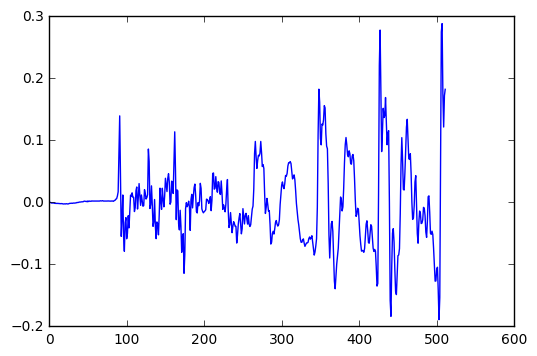

Reconstruction


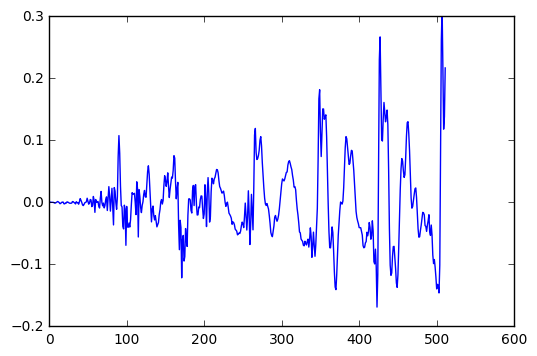

Code (pre-quantization)


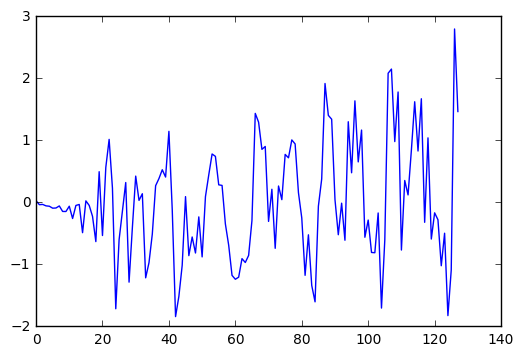

Error


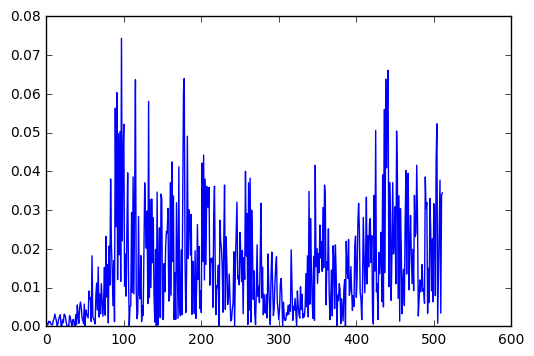

In [42]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Code (argmax)"
    argmax_code_vec = embed[idx]
    embed_sum = np.sum(embed[idx], axis = -1)
    argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
    argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
    argmax_code_vec = unquantize_vec(argmax_code_vec).eval()
    plt.plot(argmax_code_vec)
    plt.show()
    
    print "Code (non-argmax)"
    na_code_vec = embed[idx]
    na_code_vec = unquantize_vec(na_code_vec).eval()
    plt.plot(na_code_vec)
    plt.show()
    
    print "Difference"
    plt.plot(abs(argmax_code_vec - na_code_vec))
    plt.show()
else:
    print "Code (pre-quantization)"
    code_vec = embed[idx][:, :VEC_SIZE].flatten()
    plt.plot(code_vec)
    plt.show()
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()